# 第7章 機械学習の前処理を行う10本ノック

In [118]:
ENV["LINES"] = 10

10

In [119]:
using DataFrames
using DataFramesMeta
using CSV
using MLJ
using Gadfly
using HypothesisTests
using StatsBase
using FreqTables
using MLDataPattern

## 81

In [120]:
dataset_df = CSV.read(download("https://raw.githubusercontent.com/mwaskom/seaborn-data/master/titanic.csv"), DataFrame)

Row,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
,Int64,Int64,String7,Float64?,Int64,Int64,Float64,String1?,String7,String7,Bool,String1?,String15?,String3,Bool
1,0,3,male,22.0,1,0,7.25,S,Third,man,true,missing,Southampton,no,false
2,1,1,female,38.0,1,0,71.2833,C,First,woman,false,C,Cherbourg,yes,false
3,1,3,female,26.0,0,0,7.925,S,Third,woman,false,missing,Southampton,yes,true
4,1,1,female,35.0,1,0,53.1,S,First,woman,false,C,Southampton,yes,false
5,0,3,male,35.0,0,0,8.05,S,Third,man,true,missing,Southampton,no,true
6,0,3,male,missing,0,0,8.4583,Q,Third,man,true,missing,Queenstown,no,true
7,0,1,male,54.0,0,0,51.8625,S,First,man,true,E,Southampton,no,true
8,0,3,male,2.0,3,1,21.075,S,Third,child,false,missing,Southampton,no,false
9,1,3,female,27.0,0,2,11.1333,S,Third,woman,false,missing,Southampton,yes,false


In [121]:
label = dataset_df.survived
dataset2_df = select(dataset_df, Not(:survived))

Row,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
,Int64,String7,Float64?,Int64,Int64,Float64,String1?,String7,String7,Bool,String1?,String15?,String3,Bool
1,3,male,22.0,1,0,7.25,S,Third,man,true,missing,Southampton,no,false
2,1,female,38.0,1,0,71.2833,C,First,woman,false,C,Cherbourg,yes,false
3,3,female,26.0,0,0,7.925,S,Third,woman,false,missing,Southampton,yes,true
4,1,female,35.0,1,0,53.1,S,First,woman,false,C,Southampton,yes,false
5,3,male,35.0,0,0,8.05,S,Third,man,true,missing,Southampton,no,true
6,3,male,missing,0,0,8.4583,Q,Third,man,true,missing,Queenstown,no,true
7,1,male,54.0,0,0,51.8625,S,First,man,true,E,Southampton,no,true
8,3,male,2.0,3,1,21.075,S,Third,child,false,missing,Southampton,no,false
9,3,female,27.0,0,2,11.1333,S,Third,woman,false,missing,Southampton,yes,false


## 82

In [122]:
(train_df, test_df), (train_label, test_label) = partition((dataset2_df, label), 0.7; rng=1234, stratify=label, multi=true)

((623×14 DataFrame
 Row │ pclass  sex      age        sibsp  parch  fare     embarked  class    w ⋯
     │ Int64   String7  Float64?   Int64  Int64  Float64  String1?  String7  S ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │      2  male          51.0      0      0  12.525   S         Second   m ⋯
  ⋮  │   ⋮        ⋮         ⋮        ⋮      ⋮       ⋮        ⋮         ⋮       ⋱
                                                  6 columns and 622 rows omitted, 268×14 DataFrame
 Row │ pclass  sex      age        sibsp  parch  fare     embarked  class    w ⋯
     │ Int64   String7  Float64?   Int64  Int64  Float64  String1?  String7  S ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │      1  female        24.0      0      0  83.1583  C         First    w ⋯
  ⋮  │   ⋮        ⋮         ⋮        ⋮      ⋮       ⋮        ⋮         ⋮       ⋱
                                                  6 columns and 267 rows

## 83

In [123]:
select!(train_df, Not([:embark_town, :alive]))

Row,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,alone
,Int64,String7,Float64?,Int64,Int64,Float64,String1?,String7,String7,Bool,String1?,Bool
1,2,male,51.0,0,0,12.525,S,Second,man,true,missing,true
2,3,male,28.0,0,0,22.525,S,Third,man,true,missing,true
3,3,female,13.0,0,0,7.2292,C,Third,child,false,missing,true
4,3,male,missing,0,0,8.05,S,Third,man,true,missing,true
5,3,male,missing,2,0,21.6792,C,Third,man,true,missing,false
6,2,male,59.0,0,0,13.5,S,Second,man,true,missing,true
7,3,male,20.0,0,0,7.8542,S,Third,man,true,missing,true
8,1,male,49.0,1,1,110.883,C,First,man,true,C,false
9,3,male,21.0,0,0,8.05,S,Third,man,true,missing,true


In [124]:
ux = unique(train_df.sex); DataFrames.transform(train_df, @. :sex => ByRow(isequal(ux)) .=> Symbol(:sex_, ux))

Row,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,alone,sex_male,sex_female
,Int64,String7,Float64?,Int64,Int64,Float64,String1?,String7,String7,Bool,String1?,Bool,Bool,Bool
1,2,male,51.0,0,0,12.525,S,Second,man,true,missing,true,true,false
2,3,male,28.0,0,0,22.525,S,Third,man,true,missing,true,true,false
3,3,female,13.0,0,0,7.2292,C,Third,child,false,missing,true,false,true
4,3,male,missing,0,0,8.05,S,Third,man,true,missing,true,true,false
5,3,male,missing,2,0,21.6792,C,Third,man,true,missing,false,true,false
6,2,male,59.0,0,0,13.5,S,Second,man,true,missing,true,true,false
7,3,male,20.0,0,0,7.8542,S,Third,man,true,missing,true,true,false
8,1,male,49.0,1,1,110.883,C,First,man,true,C,false,true,false
9,3,male,21.0,0,0,8.05,S,Third,man,true,missing,true,true,false


In [125]:
unique_class = unique(train_df.class)
unique_class_d = Dict(zip(unique_class, 1:length(unique_class)))
DataFrames.transform(train_df, :class => ByRow(x -> unique_class_d[x]) => :class)

Row,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,alone
,Int64,String7,Float64?,Int64,Int64,Float64,String1?,Int64,String7,Bool,String1?,Bool
1,2,male,51.0,0,0,12.525,S,1,man,true,missing,true
2,3,male,28.0,0,0,22.525,S,2,man,true,missing,true
3,3,female,13.0,0,0,7.2292,C,2,child,false,missing,true
4,3,male,missing,0,0,8.05,S,2,man,true,missing,true
5,3,male,missing,2,0,21.6792,C,2,man,true,missing,false
6,2,male,59.0,0,0,13.5,S,1,man,true,missing,true
7,3,male,20.0,0,0,7.8542,S,2,man,true,missing,true
8,1,male,49.0,1,1,110.883,C,3,man,true,C,false
9,3,male,21.0,0,0,8.05,S,2,man,true,missing,true


In [126]:
function delete_column(df, column_l)
    available_column_l = []
    for column_i in column_l
        if column_i in names(df)
            append!(column_i)
        end
    end
    if length(available_column_l)
        return df
    end
    return select(df, Not(available_column_l))
end
function get_dummies(df)
    column_l = names(train_df, Union{AbstractString, Missing})
    column_l = vcat(column_l, "pclass")
    for column_i in column_l
        unique_l = unique(df[!, Symbol(column_i)])
        df = DataFrames.transform(df, @. Symbol(column_i) => ByRow(isequal(unique_l)) .=> Symbol("$(column_i)_", unique_l))
        select!(df, Not(column_i))
    end
    return df
end

get_dummies (generic function with 1 method)

In [127]:
train_df = get_dummies(train_df)

Row,age,sibsp,parch,fare,adult_male,alone,sex_male,sex_female,embarked_S,embarked_C,embarked_Q,embarked_missing,class_Second,class_Third,class_First,who_man,who_child,who_woman,deck_missing,deck_C,deck_A,deck_B,deck_D,deck_E,deck_F,deck_G,pclass_2,pclass_3,pclass_1
,Float64?,Int64,Int64,Float64,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool
1,51.0,0,0,12.525,true,true,true,false,true,false,false,false,true,false,false,true,false,false,true,false,false,false,false,false,false,false,true,false,false
2,28.0,0,0,22.525,true,true,true,false,true,false,false,false,false,true,false,true,false,false,true,false,false,false,false,false,false,false,false,true,false
3,13.0,0,0,7.2292,false,true,false,true,false,true,false,false,false,true,false,false,true,false,true,false,false,false,false,false,false,false,false,true,false
4,missing,0,0,8.05,true,true,true,false,true,false,false,false,false,true,false,true,false,false,true,false,false,false,false,false,false,false,false,true,false
5,missing,2,0,21.6792,true,false,true,false,false,true,false,false,false,true,false,true,false,false,true,false,false,false,false,false,false,false,false,true,false
6,59.0,0,0,13.5,true,true,true,false,true,false,false,false,true,false,false,true,false,false,true,false,false,false,false,false,false,false,true,false,false
7,20.0,0,0,7.8542,true,true,true,false,true,false,false,false,false,true,false,true,false,false,true,false,false,false,false,false,false,false,false,true,false
8,49.0,1,1,110.883,true,false,true,false,false,true,false,false,false,false,true,true,false,false,false,true,false,false,false,false,false,false,false,false,true
9,21.0,0,0,8.05,true,true,true,false,true,false,false,false,false,true,false,true,false,false,true,false,false,false,false,false,false,false,false,true,false


In [128]:
iqr_df = @chain train_df begin
    describe(:q25, :q75)
    @transform begin
        @astable begin
            :iqr = :q75 - :q25
            :mx = :q75 + 1.5 * :iqr
            :mn = :q25 - 1.5 * :iqr
        end
    end
    @select(:variable, :mx, :mn)
end

Row,variable,mx,mn
,Symbol,Float64,Float64
1,age,65.0,-7.0
2,sibsp,2.5,-1.5
3,parch,0.0,0.0
4,fare,66.3,-27.1
5,adult_male,2.5,-1.5
6,alone,2.5,-1.5
7,sex_male,2.5,-1.5
8,sex_female,2.5,-1.5
9,embarked_S,1.75,-0.25


In [129]:
for column_i in names(train_df)
    idx = iqr_df.variable .== :age
    # minimum
    smn = sum(skipmissing(train_df[!, Symbol(column_i)] .<= iqr_df[idx, :mn]))
    # max
    smx = sum(skipmissing(train_df[!, Symbol(column_i)] .>= iqr_df[idx, :mx]))
    println(column_i, " ", smn + smx)
end

age 9
sibsp 0
parch 0
fare 84
adult_male 0
alone 0
sex_male 0
sex_female 0
embarked_S 0
embarked_C 0
embarked_Q 0
embarked_missing 0
class_Second 0
class_Third 0
class_First 0
who_man 0
who_child 0
who_woman 0
deck_missing 0
deck_C 0
deck_A 0
deck_B 0
deck_D 0
deck_E 0
deck_F 0
deck_G 0
pclass_2 0
pclass_3 0
pclass_1 0


## 85

In [130]:
describe(train_df, :all)

Row,variable,mean,std,min,q25,median,q75,max,nunique,nuniqueall,nmissing,nnonmissing,first,last,eltype
,Symbol,Float64,Float64,Real,Float64,Float64,Float64,Real,Nothing,Int64,Int64,Int64,Real,Real,Type
1,age,29.783,14.6713,0.67,20.0,28.0,38.0,80.0,,84,115,508,51.0,18.0,"Union{Missing, Float64}"
2,sibsp,0.545746,1.14007,0,0.0,0.0,1.0,8,,7,0,623,0,1,Int64
3,parch,0.372392,0.795491,0,0.0,0.0,0.0,5,,6,0,623,0,0,Int64
4,fare,32.281,48.7217,0.0,7.925,14.4542,31.275,512.329,,214,0,623,12.525,6.4958,Float64
5,adult_male,0.605136,0.489214,false,0.0,1.0,1.0,true,,2,0,623,true,true,Bool
6,alone,0.597111,0.490873,false,0.0,1.0,1.0,true,,2,0,623,true,false,Bool
7,sex_male,0.651685,0.476819,false,0.0,1.0,1.0,true,,2,0,623,true,true,Bool
8,sex_female,0.348315,0.476819,false,0.0,0.0,1.0,true,,2,0,623,false,false,Bool
9,embarked_S,0.749599,0.433592,false,0.5,1.0,1.0,true,,2,0,623,true,true,Bool


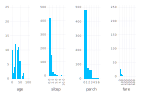

In [131]:
p1 = plot(train_df, x=:age, Geom.histogram)
p2 = plot(train_df, x=:sibsp, Geom.histogram)
p3 = plot(train_df, x=:parch, Geom.histogram)
p4 = plot(train_df, x=:fare, Geom.histogram)
hstack(p1, p2, p3, p4)

In [132]:
x = [count(==(i), skipmissing(train_df.age)) for i in 0:60]
ChisqTest(x)

Pearson's Chi-square Test
-------------------------
Population details:
    parameter of interest:   Multinomial Probabilities
    value under h_0:         [0.0163934, 0.0163934, 0.0163934, 0.0163934, 0.0163934, 0.0163934, 0.0163934, 0.0163934, 0.0163934, 0.0163934  …  0.0163934, 0.0163934, 0.0163934, 0.0163934, 0.0163934, 0.0163934, 0.0163934, 0.0163934, 0.0163934, 0.0163934]
    point estimate:          [0.0, 0.00843882, 0.0126582, 0.00843882, 0.0147679, 0.00632911, 0.00632911, 0.00421941, 0.00421941, 0.0147679  …  0.0126582, 0.0105485, 0.0021097, 0.0126582, 0.0021097, 0.00421941, 0.00421941, 0.00843882, 0.00421941, 0.00632911]
    95% confidence interval: [(0.0, 0.02613), (0.0, 0.03457), (0.0, 0.03879), (0.0, 0.03457), (0.0, 0.0409), (0.0, 0.03246), (0.0, 0.03246), (0.0, 0.03035), (0.0, 0.03035), (0.0, 0.0409)  …  (0.0, 0.03879), (0.0, 0.03668), (0.0, 0.02824), (0.0, 0.03879), (0.0, 0.02824), (0.0, 0.03035), (0.0, 0.03035), (0.0, 0.03457), (0.0, 0.03035), (0.0, 0.03246)]

Test summa

In [133]:
x = [count(==(i), skipmissing(train_df.sibsp)) for i in 0:60]
ChisqTest(x)

Pearson's Chi-square Test
-------------------------
Population details:
    parameter of interest:   Multinomial Probabilities
    value under h_0:         [0.0163934, 0.0163934, 0.0163934, 0.0163934, 0.0163934, 0.0163934, 0.0163934, 0.0163934, 0.0163934, 0.0163934  …  0.0163934, 0.0163934, 0.0163934, 0.0163934, 0.0163934, 0.0163934, 0.0163934, 0.0163934, 0.0163934, 0.0163934]
    point estimate:          [0.670947, 0.24077, 0.0369181, 0.0192616, 0.0160514, 0.00642055, 0.0, 0.0, 0.00963082, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    95% confidence interval: [(0.634, 0.7081), (0.2039, 0.2779), (0.0, 0.07407), (0.0, 0.05641), (0.0, 0.0532), (0.0, 0.04357), (0.0, 0.03715), (0.0, 0.03715), (0.0, 0.04678), (0.0, 0.03715)  …  (0.0, 0.03715), (0.0, 0.03715), (0.0, 0.03715), (0.0, 0.03715), (0.0, 0.03715), (0.0, 0.03715), (0.0, 0.03715), (0.0, 0.03715), (0.0, 0.03715), (0.0, 0.03715)]

Test summary:
    outcome with 95% confidence: reject h_0
    one-sided p-value:          

In [134]:
x = [count(==(i), skipmissing(train_df.parch)) for i in 0:60]
ChisqTest(x)

Pearson's Chi-square Test
-------------------------
Population details:
    parameter of interest:   Multinomial Probabilities
    value under h_0:         [0.0163934, 0.0163934, 0.0163934, 0.0163934, 0.0163934, 0.0163934, 0.0163934, 0.0163934, 0.0163934, 0.0163934  …  0.0163934, 0.0163934, 0.0163934, 0.0163934, 0.0163934, 0.0163934, 0.0163934, 0.0163934, 0.0163934, 0.0163934]
    point estimate:          [0.76886, 0.123596, 0.0914928, 0.00481541, 0.00481541, 0.00642055, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    95% confidence interval: [(0.7384, 0.802), (0.0931, 0.1568), (0.061, 0.1247), (0.0, 0.038), (0.0, 0.038), (0.0, 0.03961), (0.0, 0.03319), (0.0, 0.03319), (0.0, 0.03319), (0.0, 0.03319)  …  (0.0, 0.03319), (0.0, 0.03319), (0.0, 0.03319), (0.0, 0.03319), (0.0, 0.03319), (0.0, 0.03319), (0.0, 0.03319), (0.0, 0.03319), (0.0, 0.03319), (0.0, 0.03319)]

Test summary:
    outcome with 95% confidence: reject h_0
    one-sided p-value:           <1e-99

In [135]:
x = [count(==(i), skipmissing(train_df.fare)) for i in 0:60]
ChisqTest(x)

Pearson's Chi-square Test
-------------------------
Population details:
    parameter of interest:   Multinomial Probabilities
    value under h_0:         [0.0163934, 0.0163934, 0.0163934, 0.0163934, 0.0163934, 0.0163934, 0.0163934, 0.0163934, 0.0163934, 0.0163934  …  0.0163934, 0.0163934, 0.0163934, 0.0163934, 0.0163934, 0.0163934, 0.0163934, 0.0163934, 0.0163934, 0.0163934]
    point estimate:          [0.0909091, 0.0, 0.0, 0.0, 0.0, 0.010101, 0.0, 0.0, 0.0, 0.020202  …  0.0, 0.040404, 0.0, 0.0, 0.010101, 0.0, 0.020202, 0.0, 0.0, 0.0]
    95% confidence interval: [(0.0, 0.1867), (0.0, 0.09578), (0.0, 0.09578), (0.0, 0.09578), (0.0, 0.09578), (0.0, 0.1059), (0.0, 0.09578), (0.0, 0.09578), (0.0, 0.09578), (0.0, 0.116)  …  (0.0, 0.09578), (0.0, 0.1362), (0.0, 0.09578), (0.0, 0.09578), (0.0, 0.1059), (0.0, 0.09578), (0.0, 0.116), (0.0, 0.09578), (0.0, 0.09578), (0.0, 0.09578)]

Test summary:
    outcome with 95% confidence: reject h_0
    one-sided p-value:           <1e-99

Details:
  

## 86

In [136]:
tmp_zscore = zscore(collect(skipmissing(train_df.age)))
j = 1
for i in 1:length(train_df.age)
    if ismissing(train_df.age[i])
        continue
    end
    train_df[i, :age] = tmp_zscore[j]
    j += 1
end

In [137]:
train_df[:, :sibsp] = collect(winsor(train_df.sibsp, prop=0.25))

623-element Vector{Int64}:
 0
 0
 0
 ⋮
 0
 1

In [138]:
train_df[:, :parc] = collect(winsor(train_df.parch, prop=0.25))

623-element Vector{Int64}:
 0
 0
 0
 ⋮
 0
 0

In [139]:
train_df[:, :fare] = collect(winsor(train_df.fare, prop=0.25))

623-element Vector{Float64}:
 12.525
 22.525
  7.925
  ⋮
 31.275
  7.925

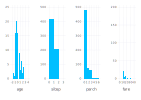

In [140]:
p1 = plot(train_df, x=:age, Geom.histogram)
p2 = plot(train_df, x=:sibsp, Geom.histogram)
p3 = plot(train_df, x=:parch, Geom.histogram)
p4 = plot(train_df, x=:fare, Geom.histogram)
hstack(p1, p2, p3, p4)

## 87

## 88

In [141]:
describe(train_df)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,Type
1,age,6.60014e-17,-1.98434,-0.121528,3.4228,115,"Union{Missing, Float64}"
2,sibsp,0.329053,0,0.0,1,0,Int64
3,parch,0.372392,0,0.0,5,0,Int64
4,fare,18.1448,7.925,14.4542,31.275,0,Float64
5,adult_male,0.605136,false,1.0,true,0,Bool
6,alone,0.597111,false,1.0,true,0,Bool
7,sex_male,0.651685,false,1.0,true,0,Bool
8,sex_female,0.348315,false,0.0,true,0,Bool
9,embarked_S,0.749599,false,1.0,true,0,Bool


In [143]:
train_df = @chain train_df begin
    @transform(age2 = coalesce.(:age, median(skipmissing(:age))))
end

┌ Warning: Using an un-quoted Symbol on the LHS is deprecated. Write :age2 = ... instead.
└ @ DataFramesMeta /workspaces/100knock-process-visualization/.julia/packages/DataFramesMeta/hLirN/src/parsing.jl:363


Row,age,sibsp,parch,fare,adult_male,alone,sex_male,sex_female,embarked_S,embarked_C,embarked_Q,embarked_missing,class_Second,class_Third,class_First,who_man,who_child,who_woman,deck_missing,deck_C,deck_A,deck_B,deck_D,deck_E,deck_F,deck_G,pclass_2,pclass_3,pclass_1,parc,age2
,Float64?,Int64,Int64,Float64,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Int64,Float64
1,1.44615,0,0,12.525,true,true,true,false,true,false,false,false,true,false,false,true,false,false,true,false,false,false,false,false,false,false,true,false,false,0,1.44615
2,-0.121528,0,0,22.525,true,true,true,false,true,false,false,false,false,true,false,true,false,false,true,false,false,false,false,false,false,false,false,true,false,0,-0.121528
3,-1.14393,0,0,7.925,false,true,false,true,false,true,false,false,false,true,false,false,true,false,true,false,false,false,false,false,false,false,false,true,false,0,-1.14393
4,missing,0,0,8.05,true,true,true,false,true,false,false,false,false,true,false,true,false,false,true,false,false,false,false,false,false,false,false,true,false,0,-0.121528
5,missing,1,0,21.6792,true,false,true,false,false,true,false,false,false,true,false,true,false,false,true,false,false,false,false,false,false,false,false,true,false,0,-0.121528
6,1.99144,0,0,13.5,true,true,true,false,true,false,false,false,true,false,false,true,false,false,true,false,false,false,false,false,false,false,true,false,false,0,1.99144
7,-0.666808,0,0,7.925,true,true,true,false,true,false,false,false,false,true,false,true,false,false,true,false,false,false,false,false,false,false,false,true,false,0,-0.666808
8,1.30983,1,1,31.275,true,false,true,false,false,true,false,false,false,false,true,true,false,false,false,true,false,false,false,false,false,false,false,false,true,0,1.30983
9,-0.598648,0,0,8.05,true,true,true,false,true,false,false,false,false,true,false,true,false,false,true,false,false,false,false,false,false,false,false,true,false,0,-0.598648


In [144]:
describe(train_df)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,Type
1,age,6.60014e-17,-1.98434,-0.121528,3.4228,115,"Union{Missing, Float64}"
2,sibsp,0.329053,0,0.0,1,0,Int64
3,parch,0.372392,0,0.0,5,0,Int64
4,fare,18.1448,7.925,14.4542,31.275,0,Float64
5,adult_male,0.605136,false,1.0,true,0,Bool
6,alone,0.597111,false,1.0,true,0,Bool
7,sex_male,0.651685,false,1.0,true,0,Bool
8,sex_female,0.348315,false,0.0,true,0,Bool
9,embarked_S,0.749599,false,1.0,true,0,Bool


In [145]:
count(label)

TypeError: TypeError: non-boolean (Int64) used in boolean context

In [146]:
countmap(label)

Dict{Int64, Int64} with 2 entries:
  0 => 549
  1 => 342

In [160]:
(undersample_idx, undersample_train_label) = undersample((1:size(train_df)[1], train_label))
undersample_train_df = train_df[undersample_idx, :]

Row,age,sibsp,parch,fare,adult_male,alone,sex_male,sex_female,embarked_S,embarked_C,embarked_Q,embarked_missing,class_Second,class_Third,class_First,who_man,who_child,who_woman,deck_missing,deck_C,deck_A,deck_B,deck_D,deck_E,deck_F,deck_G,pclass_2,pclass_3,pclass_1,parc,age2
,Float64?,Int64,Int64,Float64,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Int64,Float64
1,-0.121528,0,0,22.525,true,true,true,false,true,false,false,false,false,true,false,true,false,false,true,false,false,false,false,false,false,false,false,true,false,0,-0.121528
2,-1.14393,0,0,7.925,false,true,false,true,false,true,false,false,false,true,false,false,true,false,true,false,false,false,false,false,false,false,false,true,false,0,-1.14393
3,missing,1,0,21.6792,true,false,true,false,false,true,false,false,false,true,false,true,false,false,true,false,false,false,false,false,false,false,false,true,false,0,-0.121528
4,-0.666808,0,0,7.925,true,true,true,false,true,false,false,false,false,true,false,true,false,false,true,false,false,false,false,false,false,false,false,true,false,0,-0.666808
5,-0.598648,0,0,8.05,true,true,true,false,true,false,false,false,false,true,false,true,false,false,true,false,false,false,false,false,false,false,false,true,false,0,-0.598648
6,0.560073,0,0,8.6625,true,true,true,false,true,false,false,false,false,true,false,true,false,false,true,false,false,false,false,false,false,false,false,true,false,0,0.560073
7,missing,0,0,31.275,true,true,true,false,true,false,false,false,false,false,true,true,false,false,false,false,true,false,false,false,false,false,false,false,true,0,-0.121528
8,-0.0533675,0,0,9.5,true,true,true,false,true,false,false,false,false,true,false,true,false,false,true,false,false,false,false,false,false,false,false,true,false,0,-0.0533675
9,1.71879,0,0,30.5,true,true,true,false,true,false,false,false,false,false,true,true,false,false,false,true,false,false,false,false,false,false,false,false,true,0,1.71879


In [161]:
countmap(undersample_train_label)

Dict{Int64, Int64} with 2 entries:
  0 => 239
  1 => 239

In [162]:
(oversample_idx, oversample_train_label) = oversample((1:size(train_df)[1], train_label))
oversample_train_df = train_df[oversample_idx, :]

Row,age,sibsp,parch,fare,adult_male,alone,sex_male,sex_female,embarked_S,embarked_C,embarked_Q,embarked_missing,class_Second,class_Third,class_First,who_man,who_child,who_woman,deck_missing,deck_C,deck_A,deck_B,deck_D,deck_E,deck_F,deck_G,pclass_2,pclass_3,pclass_1,parc,age2
,Float64?,Int64,Int64,Float64,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Int64,Float64
1,0.423753,0,1,31.275,true,false,true,false,false,true,false,false,false,false,true,true,false,false,false,false,false,true,false,false,false,false,false,false,true,0,0.423753
2,1.03719,0,0,8.05,true,true,true,false,true,false,false,false,false,true,false,true,false,false,true,false,false,false,false,false,false,false,false,true,false,0,1.03719
3,-0.803128,1,1,20.2125,true,false,true,false,true,false,false,false,false,true,false,true,false,false,true,false,false,false,false,false,false,false,false,true,false,0,-0.803128
4,-0.462328,0,0,13.0,true,true,true,false,true,false,false,false,true,false,false,true,false,false,true,false,false,false,false,false,false,false,true,false,false,0,-0.462328
5,-0.530488,0,0,7.925,true,true,true,false,false,true,false,false,false,true,false,true,false,false,true,false,false,false,false,false,false,false,false,true,false,0,-0.530488
6,-0.121528,0,0,13.0,false,true,false,true,true,false,false,false,true,false,false,false,false,true,true,false,false,false,false,false,false,false,true,false,false,0,-0.121528
7,missing,0,0,7.925,true,true,true,false,true,false,false,false,true,false,false,true,false,false,true,false,false,false,false,false,false,false,true,false,false,0,-0.121528
8,-1.68921,1,1,19.2583,false,false,false,true,false,true,false,false,false,true,false,false,true,false,true,false,false,false,false,false,false,false,false,true,false,0,-1.68921
9,0.900874,0,1,31.275,false,false,false,true,true,false,false,false,false,false,true,false,false,true,false,false,false,true,false,false,false,false,false,false,true,0,0.900874


In [163]:
countmap(oversample_train_label)

Dict{Int64, Int64} with 2 entries:
  0 => 384
  1 => 384

## 90